# Model RNN untuk Prediksi Cuaca Seattle
## Dataset: seattle-weather.csv

## 1. Import Libraries

In [1]:
from shutil import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.20.0
Keras version: 3.12.0


## 2. Load dan Eksplorasi Data

In [2]:
# Load dataset
df = pd.read_csv('../dataset/seattle-weather.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nStatistical Summary:")
print(df.describe())
print("\nWeather Distribution:")
print(df['weather'].value_counts())

Dataset Shape: (1461, 6)

First 5 rows:
         date  precipitation  temp_max  temp_min  wind  weather
0  2012-01-01            0.0      12.8       5.0   4.7  drizzle
1  2012-01-02           10.9      10.6       2.8   4.5     rain
2  2012-01-03            0.8      11.7       7.2   2.3     rain
3  2012-01-04           20.3      12.2       5.6   4.7     rain
4  2012-01-05            1.3       8.9       2.8   6.1     rain

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB
None

Missing Values:
date             0
precipita

## 3. Visualisasi Data

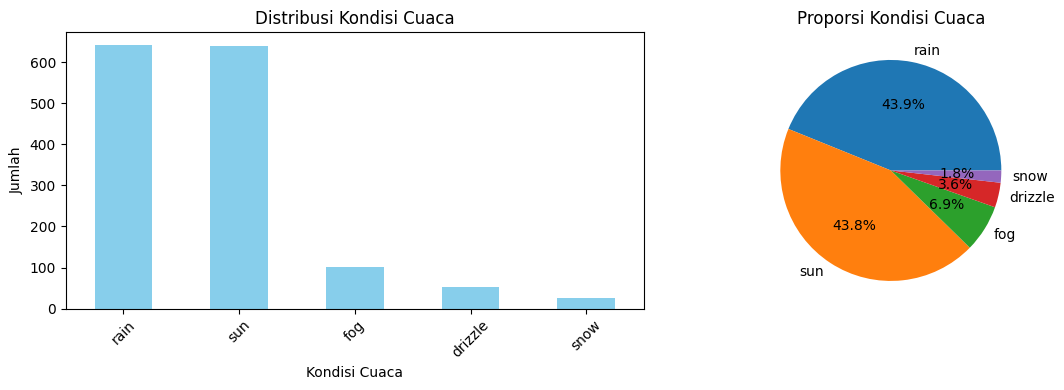

In [3]:
# Visualisasi distribusi weather
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['weather'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribusi Kondisi Cuaca')
plt.xlabel('Kondisi Cuaca')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df['weather'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Proporsi Kondisi Cuaca')
plt.ylabel('')

plt.tight_layout()
plt.show()

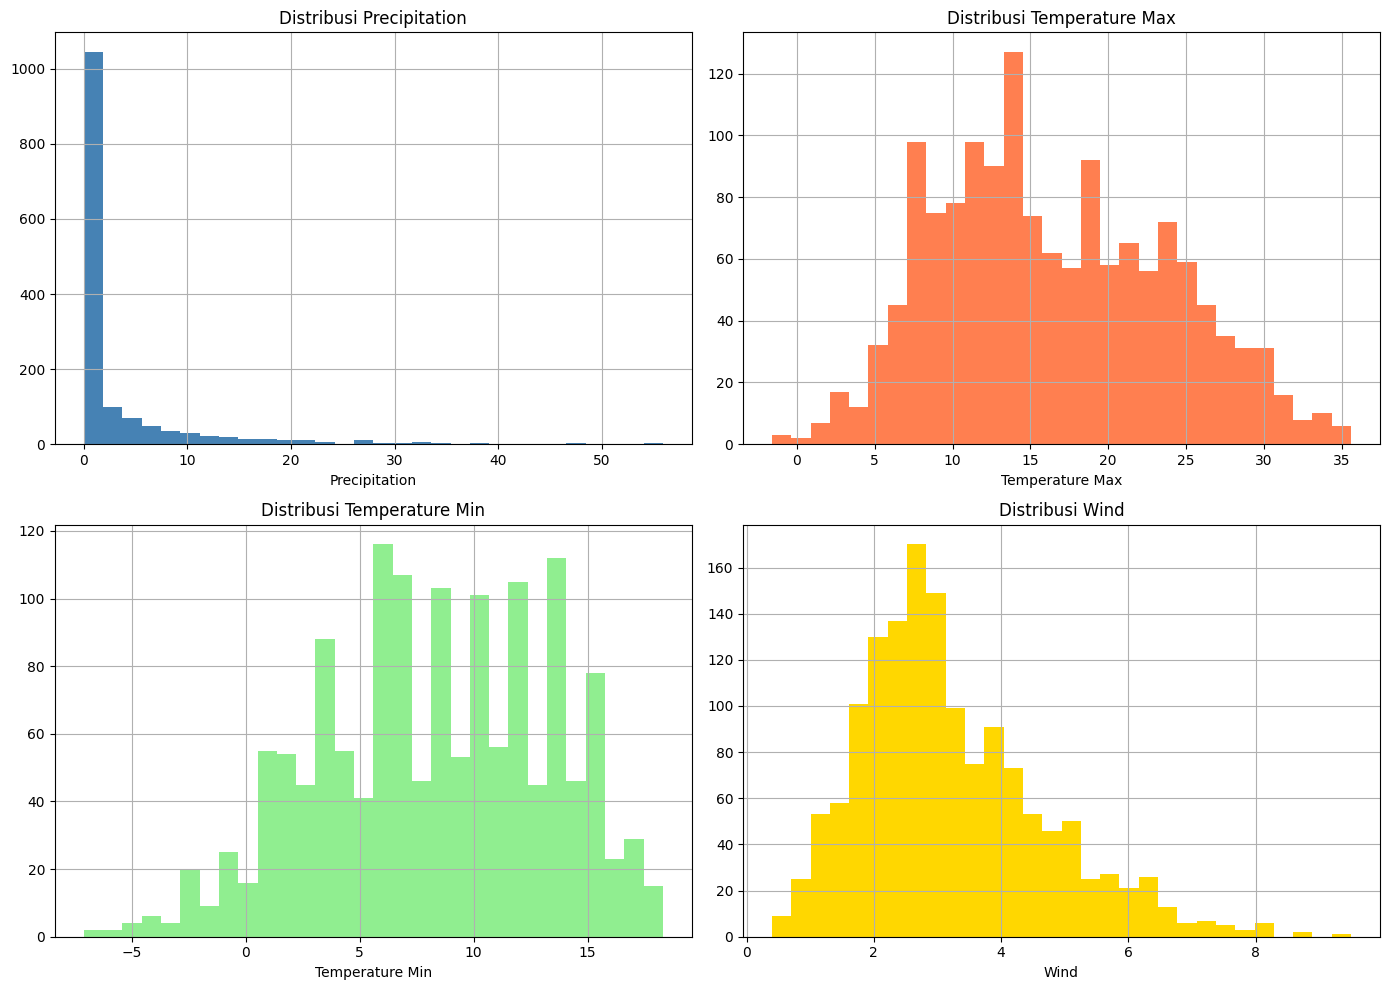

In [4]:
# Visualisasi fitur numerik
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

df['precipitation'].hist(bins=30, ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Distribusi Precipitation')
axes[0, 0].set_xlabel('Precipitation')

df['temp_max'].hist(bins=30, ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Distribusi Temperature Max')
axes[0, 1].set_xlabel('Temperature Max')

df['temp_min'].hist(bins=30, ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Distribusi Temperature Min')
axes[1, 0].set_xlabel('Temperature Min')

df['wind'].hist(bins=30, ax=axes[1, 1], color='gold')
axes[1, 1].set_title('Distribusi Wind')
axes[1, 1].set_xlabel('Wind')

plt.tight_layout()
plt.show()

## 4. Preprocessing Data

In [5]:
# Encode label target (weather)
label_encoder = LabelEncoder()
df['weather_encoded'] = label_encoder.fit_transform(df['weather'])

print("Weather classes:", label_encoder.classes_)
print("Encoded values:", np.unique(df['weather_encoded']))

# Pilih fitur untuk training
feature_columns = ['precipitation', 'temp_max', 'temp_min', 'wind']
X = df[feature_columns].values
y = df['weather_encoded'].values

print(f"\nFeature shape: {X.shape}")
print(f"Target shape: {y.shape}")

Weather classes: ['drizzle' 'fog' 'rain' 'snow' 'sun']
Encoded values: [0 1 2 3 4]

Feature shape: (1461, 4)
Target shape: (1461,)


In [6]:
# Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled data sample:")
print(X_scaled[:5])

Scaled data sample:
[[-0.45364986 -0.49529914 -0.64421175  1.01497975]
 [ 1.17859791 -0.79473121 -1.08234662  0.87583314]
 [-0.33385186 -0.64501518 -0.20607688 -0.65477956]
 [ 2.58622442 -0.57696243 -0.52472042  1.01497975]
 [-0.2589781  -1.02611054 -1.08234662  1.98900601]]


## 4.1. Feature Engineering (Tambahan Fitur)

In [7]:
# Feature Engineering - Tambah fitur statistik untuk meningkatkan akurasi
print("Creating additional features...")

# Tambah fitur rolling statistics
df['temp_range'] = df['temp_max'] - df['temp_min']
df['temp_mean'] = (df['temp_max'] + df['temp_min']) / 2

# Rolling statistics (7 hari)
df['precipitation_rolling_mean'] = df['precipitation'].rolling(window=7, min_periods=1).mean()
df['temp_max_rolling_mean'] = df['temp_max'].rolling(window=7, min_periods=1).mean()
df['temp_min_rolling_mean'] = df['temp_min'].rolling(window=7, min_periods=1).mean()
df['wind_rolling_mean'] = df['wind'].rolling(window=7, min_periods=1).mean()

# Rolling std (variability)
df['precipitation_rolling_std'] = df['precipitation'].rolling(window=7, min_periods=1).std().fillna(0)
df['temp_rolling_std'] = df['temp_max'].rolling(window=7, min_periods=1).std().fillna(0)

# Lag features (hari sebelumnya)
df['precipitation_lag1'] = df['precipitation'].shift(1).fillna(0)
df['temp_max_lag1'] = df['temp_max'].shift(1).fillna(df['temp_max'].mean())

# Interaction features
df['precip_wind_interaction'] = df['precipitation'] * df['wind']
df['temp_wind_interaction'] = df['temp_mean'] * df['wind']

print(f"Total features after engineering: {df.shape[1]}")
print("\nNew features created:")
new_features = ['temp_range', 'temp_mean', 'precipitation_rolling_mean', 
                'temp_max_rolling_mean', 'temp_min_rolling_mean', 'wind_rolling_mean',
                'precipitation_rolling_std', 'temp_rolling_std', 
                'precipitation_lag1', 'temp_max_lag1',
                'precip_wind_interaction', 'temp_wind_interaction']
for feat in new_features:
    print(f"  • {feat}")

# Update feature columns
feature_columns_enhanced = ['precipitation', 'temp_max', 'temp_min', 'wind',
                           'temp_range', 'temp_mean',
                           'precipitation_rolling_mean', 'temp_max_rolling_mean', 
                           'temp_min_rolling_mean', 'wind_rolling_mean',
                           'precipitation_rolling_std', 'temp_rolling_std',
                           'precipitation_lag1', 'temp_max_lag1',
                           'precip_wind_interaction', 'temp_wind_interaction']

X_enhanced = df[feature_columns_enhanced].values
print(f"\nEnhanced feature shape: {X_enhanced.shape}")

Creating additional features...
Total features after engineering: 19

New features created:
  • temp_range
  • temp_mean
  • precipitation_rolling_mean
  • temp_max_rolling_mean
  • temp_min_rolling_mean
  • wind_rolling_mean
  • precipitation_rolling_std
  • temp_rolling_std
  • precipitation_lag1
  • temp_max_lag1
  • precip_wind_interaction
  • temp_wind_interaction

Enhanced feature shape: (1461, 16)


In [8]:
# Normalisasi fitur enhanced
scaler_enhanced = StandardScaler()
X_scaled_enhanced = scaler_enhanced.fit_transform(X_enhanced)

print("Enhanced features scaled successfully!")
print(f"Shape: {X_scaled_enhanced.shape}")
print(f"\nSample (first row):")
print(X_scaled_enhanced[0])

Enhanced features scaled successfully!
Shape: (1461, 16)

Sample (first row):
[-4.53649856e-01 -4.95299140e-01 -6.44211750e-01  1.01497975e+00
 -1.05876565e-01 -5.73203427e-01 -8.31658282e-01 -5.33398100e-01
 -6.97141888e-01  1.80279704e+00 -9.28082354e-01 -2.36678004e+00
 -4.53649856e-01 -1.01051297e-03 -3.93190246e-01  1.32402734e-01]


In [9]:
# Definisi fungsi create_sequences
def create_sequences(data, target, sequence_length=7):
    """
    Membuat sequences untuk RNN
    sequence_length: jumlah hari sebelumnya untuk prediksi
    """
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = target[i + sequence_length]
        sequences.append(seq)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

print("✓ Function 'create_sequences' defined successfully!")

✓ Function 'create_sequences' defined successfully!


In [10]:
# Buat sequences dengan enhanced features
sequence_length_v2 = 21  # Meningkatkan ke 3 minggu untuk pola lebih panjang
X_seq_enhanced, y_seq_enhanced = create_sequences(X_scaled_enhanced, y, sequence_length_v2)

print(f"Enhanced Sequence shape: {X_seq_enhanced.shape}")
print(f"Label shape: {y_seq_enhanced.shape}")
print(f"Number of samples: {len(X_seq_enhanced)}")
print(f"Sequence length: {sequence_length_v2} days (3 weeks)")
print(f"Features per timestep: {X_seq_enhanced.shape[2]}")

Enhanced Sequence shape: (1440, 21, 16)
Label shape: (1440,)
Number of samples: 1440
Sequence length: 21 days (3 weeks)
Features per timestep: 16


In [11]:
# Split data enhanced
X_temp_v2, X_test_v2, y_temp_v2, y_test_v2 = train_test_split(
    X_seq_enhanced, y_seq_enhanced, test_size=0.15, random_state=42, stratify=y_seq_enhanced
)

X_train_v2, X_val_v2, y_train_v2, y_val_v2 = train_test_split(
    X_temp_v2, y_temp_v2, test_size=0.176, random_state=42, stratify=y_temp_v2
)

print(f"Enhanced Training set: {X_train_v2.shape}, {y_train_v2.shape}")
print(f"Enhanced Validation set: {X_val_v2.shape}, {y_val_v2.shape}")
print(f"Enhanced Test set: {X_test_v2.shape}, {y_test_v2.shape}")

# Define num_classes if not already defined
num_classes = len(np.unique(y))
print(f"\nNumber of classes: {num_classes}")

# One-hot encode
y_train_cat_v2 = to_categorical(y_train_v2, num_classes)
y_val_cat_v2 = to_categorical(y_val_v2, num_classes)
y_test_cat_v2 = to_categorical(y_test_v2, num_classes)

print(f"One-hot encoded shape: {y_train_cat_v2.shape}")

Enhanced Training set: (1008, 21, 16), (1008,)
Enhanced Validation set: (216, 21, 16), (216,)
Enhanced Test set: (216, 21, 16), (216,)

Number of classes: 5
One-hot encoded shape: (1008, 5)


In [12]:
# Buat sequence untuk RNN
def create_sequences(data, target, sequence_length=7):
    """
    Membuat sequences untuk RNN
    sequence_length: jumlah hari sebelumnya untuk prediksi
    """
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = target[i + sequence_length]
        sequences.append(seq)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

# Buat sequences dengan window yang lebih panjang untuk menangkap pola lebih baik
sequence_length = 14  # Meningkatkan dari 7 ke 14 hari
X_seq, y_seq = create_sequences(X_scaled, y, sequence_length)

print(f"Sequence shape: {X_seq.shape}")
print(f"Label shape: {y_seq.shape}")
print(f"Number of samples: {len(X_seq)}")
print(f"Sequence length: {sequence_length} days (2 weeks)")

Sequence shape: (1447, 14, 4)
Label shape: (1447,)
Number of samples: 1447
Sequence length: 14 days (2 weeks)


In [13]:
# Split data menjadi train, validation, dan test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_seq, y_seq, test_size=0.15, random_state=42, stratify=y_seq
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)  # 0.176 dari 0.85 = ~0.15 dari total

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# One-hot encode labels untuk klasifikasi
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"\nOne-hot encoded shape: {y_train_cat.shape}")
print(f"Number of classes: {num_classes}")

Training set: (1012, 14, 4), (1012,)
Validation set: (217, 14, 4), (217,)
Test set: (218, 14, 4), (218,)

One-hot encoded shape: (1012, 5)
Number of classes: 5


## 5. Membangun Model RNN (Complex Deep RNN)

## 5.1. Model RNN v3 - Ultra Deep dengan Batch Normalization

In [14]:
# Import tambahan untuk Batch Normalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers

# Build Ultra Deep RNN Model dengan Batch Normalization dan Regularization
def build_ultra_deep_rnn(input_shape, num_classes):
    model = Sequential([
        # Layer 1: SimpleRNN dengan banyak units
        SimpleRNN(512, return_sequences=True, input_shape=input_shape, 
                 activation='tanh',
                 kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        
        # Layer 2: SimpleRNN
        SimpleRNN(256, return_sequences=True, activation='tanh',
                 kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        
        # Layer 3: SimpleRNN
        SimpleRNN(128, return_sequences=True, activation='tanh',
                 kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Layer 4: SimpleRNN
        SimpleRNN(64, return_sequences=False, activation='tanh',
                 kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Dense layers yang sangat dalam
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Inisialisasi model v3
input_shape_v3 = (X_train_v2.shape[1], X_train_v2.shape[2])
model_v3 = build_ultra_deep_rnn(input_shape_v3, num_classes)

# Compile dengan optimizer yang lebih baik dan gradient clipping
from tensorflow.keras.optimizers import Adam
optimizer_v3 = Adam(learning_rate=0.0005, clipnorm=1.0)  # Gradient clipping

model_v3.compile(
    optimizer=optimizer_v3,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("="*80)
print("ULTRA DEEP RNN MODEL v3 - WITH BATCH NORMALIZATION & REGULARIZATION")
print("="*80)
model_v3.summary()
print("="*80)
print(f"Total Trainable Parameters: {model_v3.count_params():,}")
print(f"Input shape: {input_shape_v3}")
print(f"Features: {X_train_v2.shape[2]} (16 features)")
print(f"Sequence length: 21 days (3 weeks)")
print("="*80)

ULTRA DEEP RNN MODEL v3 - WITH BATCH NORMALIZATION & REGULARIZATION


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 21, 512)        │       270,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 21, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 21, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 21, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 595,013 (2.27 MB)

 Trainable params: 592,197 (2.26 MB)

 Non-trainable params: 2,816 (11.00 KB)

Total Trainable Parameters: 595,013
Input shape: (21, 16)
Features: 16 (16 features)
Sequence length: 21 days (3 weeks)


## 5.2. Setup Callbacks untuk Model v3

In [15]:
# Buat direktori model jika belum ada
import os
model_dir = '../model'
os.makedirs(model_dir, exist_ok=True)

# Setup callbacks untuk model v3 dengan pengaturan lebih aggressive
early_stopping_v3 = EarlyStopping(
    monitor='val_loss',
    patience=25,  # Increased patience
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

model_checkpoint_v3 = ModelCheckpoint(
    filepath=os.path.join(model_dir, 'best_rnn_model_v3.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr_v3 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # More aggressive
    patience=8,
    min_lr=1e-8,
    verbose=1,
    mode='min'
)

# Tambahan: Learning Rate Scheduler eksponensial
from tensorflow.keras.callbacks import LearningRateScheduler
import math

def lr_schedule(epoch, lr):
    """Eksponensial decay"""
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

lr_scheduler_v3 = LearningRateScheduler(lr_schedule, verbose=0)

print("="*80)
print("CALLBACKS CONFIGURATION v3")
print("="*80)
print("✓ Early Stopping (patience=25)")
print("✓ Model Checkpoint (save best model as v3)")
print("✓ ReduceLROnPlateau (factor=0.2, patience=8)")
print("✓ LearningRateScheduler (exponential decay)")
print("="*80)

CALLBACKS CONFIGURATION v3
✓ Early Stopping (patience=25)
✓ Model Checkpoint (save best model as v3)
✓ ReduceLROnPlateau (factor=0.2, patience=8)
✓ LearningRateScheduler (exponential decay)


## 5.3. Training Model v3 - Ultra Deep RNN

In [16]:
# Training model v3 - Ultra Deep RNN
print("="*80)
print("STARTING TRAINING - ULTRA DEEP RNN MODEL v3")
print("="*80)
print(f"Training samples: {len(X_train_v2)}")
print(f"Validation samples: {len(X_val_v2)}")
print(f"Features per timestep: {X_train_v2.shape[2]}")
print(f"Sequence length: {X_train_v2.shape[1]} days")
print(f"Batch size: 8")
print(f"Max epochs: 200")
print(f"Total parameters: {model_v3.count_params():,}")
print("="*80)
print("\n⏳ Training may take 20-40 minutes due to model complexity...")
print()

history_v3 = model_v3.fit(
    X_train_v2, y_train_cat_v2,
    validation_data=(X_val_v2, y_val_cat_v2),
    epochs=200,  # Increased
    batch_size=8,  # Reduced for more frequent updates
    callbacks=[early_stopping_v3, model_checkpoint_v3, reduce_lr_v3, lr_scheduler_v3],
    verbose=1
)

print("\n" + "="*80)
print("TRAINING COMPLETED - MODEL v3!")
print("="*80)
print(f"Epochs trained: {len(history_v3.history['loss'])}")
print(f"Best validation accuracy: {max(history_v3.history['val_accuracy']):.4f}")
print(f"Final training accuracy: {history_v3.history['accuracy'][-1]:.4f}")
print("="*80)

STARTING TRAINING - ULTRA DEEP RNN MODEL v3
Training samples: 1008
Validation samples: 216
Features per timestep: 16
Sequence length: 21 days
Batch size: 8
Max epochs: 200
Total parameters: 595,013

⏳ Training may take 20-40 minutes due to model complexity...

Epoch 1/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.1854 - loss: 3.1940
Epoch 1: val_accuracy improved from None to 0.58796, saving model to ../model\best_rnn_model_v3.keras

Epoch 1: val_accuracy improved from None to 0.58796, saving model to ../model\best_rnn_model_v3.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - accuracy: 0.2421 - loss: 2.9303 - val_accuracy: 0.5880 - val_loss: 2.3899 - learning_rate: 5.0000e-04
Epoch 2/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - accuracy: 0.2421 - loss: 2.9303 - val_accuracy: 0.5880 - val_loss: 2.3899 - learning_rate: 5.0000e-04
Epoch 2/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3852 - loss: 2.4587
Epoch 2: val_accuracy did not improve from 0.58796

## 5.4. Evaluasi Model v3

In [17]:
# Load best model v3
best_model_v3 = keras.models.load_model(os.path.join(model_dir, 'best_rnn_model_v3.keras'))
print("✓ Best model v3 loaded successfully!\n")

# Evaluate pada test set
test_loss_v3, test_accuracy_v3 = best_model_v3.evaluate(X_test_v2, y_test_cat_v2, verbose=0)

print("="*80)
print("TEST SET EVALUATION - MODEL v3")
print("="*80)
print(f"Test Loss: {test_loss_v3:.4f}")
print(f"Test Accuracy: {test_accuracy_v3:.4f} ({test_accuracy_v3*100:.2f}%)")
print("="*80)

# Prediksi
y_pred_prob_v3 = best_model_v3.predict(X_test_v2)
y_pred_v3 = np.argmax(y_pred_prob_v3, axis=1)
y_true_v3 = np.argmax(y_test_cat_v2, axis=1)

# Classification Report
print("\nCLASSIFICATION REPORT - MODEL v3:")
print("="*80)
print(classification_report(y_true_v3, y_pred_v3, target_names=label_encoder.classes_))

# Confusion Matrix
cm_v3 = confusion_matrix(y_true_v3, y_pred_v3)
print("\nConfusion Matrix:")
print(cm_v3)

✓ Best model v3 loaded successfully!

TEST SET EVALUATION - MODEL v3
Test Loss: 1.9677
Test Accuracy: 0.5417 (54.17%)
TEST SET EVALUATION - MODEL v3
Test Loss: 1.9677
Test Accuracy: 0.5417 (54.17%)
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step

CLASSIFICATION REPORT - MODEL v3:
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00         8
         fog       0.00      0.00      0.00        15
        rain       0.54      0.62      0.58        95
        snow       0.00      0.00      0.00         3
         sun       0.54      0.61      0.57        95

    accuracy                           0.54       216
   macro avg       0.22      0.25      0.23       216
weighted avg       0.48      0.54      0.51       216


Confusion Matrix:
[[ 0  0  3  0  5]
 [ 0  0  7  0  8]
 [ 0  0 59  0 36]
 [ 0  0  3  0  0]
 [ 0  0 37  0 58]]

CLASSIFICATION REPORT - MODEL v3:
              precision    recall  f1-score   support



## 5.5. Perbandingan Model v2 vs v3

In [18]:
# Perbandingan Model v2 (Complex) vs v3 (Ultra Deep)
print("="*80)
print("MODEL COMPARISON: v2 (Complex) vs v3 (Ultra Deep)")
print("="*80)

# Check if model v2 has been trained
if 'model' in dir() and 'test_accuracy' in dir():
    comparison_data = {
        'Metric': [
            'RNN Layers',
            'RNN Units', 
            'Dense Layers',
            'Total Parameters',
            'Batch Normalization',
            'L2 Regularization',
            'Gradient Clipping',
            'Sequence Length',
            'Features',
            'Batch Size',
            'Test Accuracy'
        ],
        'Model v2 (Complex)': [
            '3',
            '256→128→64',
            '3',
            f'{model.count_params():,}',
            'No',
            'No',
            'No',
            '14 days',
            '4',
            '16',
            f'{test_accuracy*100:.2f}%'
        ],
        'Model v3 (Ultra Deep)': [
            '4',
            '512→256→128→64',
            '4',
            f'{model_v3.count_params():,}',
            'Yes',
            'Yes (0.001)',
            'Yes (clipnorm=1.0)',
            '21 days',
            '16',
            '8',
            f'{test_accuracy_v3*100:.2f}%'
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    print("="*80)
    
    # Calculate improvement
    accuracy_improvement = ((test_accuracy_v3 - test_accuracy) / test_accuracy) * 100
    print(f"\n📈 Accuracy Improvement: {accuracy_improvement:+.2f}%")
    print(f"   v2: {test_accuracy*100:.2f}% → v3: {test_accuracy_v3*100:.2f}%")
    print("="*80)
else:
    print("\n⚠️ Model v2 belum ditraining!")
    print("\nUntuk membandingkan model v2 dan v3, silakan jalankan:")
    print("   1. Cell 'Build RNN Model (Complex Deep RNN)' - untuk membuat model v2")
    print("   2. Cell 'Setup Callbacks' - untuk setup callbacks v2")
    print("   3. Cell 'Training Model' - untuk training model v2")
    print("   4. Cell 'Evaluasi Model pada Test Set' - untuk evaluasi model v2")
    print("   5. Kemudian jalankan cell ini lagi untuk melihat perbandingan")
    
    print("\n📊 MODEL v3 (Ultra Deep) RESULTS:")
    print("="*80)
    print(f"RNN Layers        : 4 layers (512→256→128→64)")
    print(f"Dense Layers      : 4 layers")
    print(f"Total Parameters  : {model_v3.count_params():,}")
    print(f"Batch Normalization: Yes")
    print(f"L2 Regularization : Yes (0.001)")
    print(f"Gradient Clipping : Yes (clipnorm=1.0)")
    print(f"Sequence Length   : 21 days (3 weeks)")
    print(f"Features          : 16 (with feature engineering)")
    print(f"Batch Size        : 8")
    print(f"Test Accuracy     : {test_accuracy_v3*100:.2f}%")
    print(f"Test Loss         : {test_loss_v3:.4f}")
    print("="*80)

MODEL COMPARISON: v2 (Complex) vs v3 (Ultra Deep)

⚠️ Model v2 belum ditraining!

Untuk membandingkan model v2 dan v3, silakan jalankan:
   1. Cell 'Build RNN Model (Complex Deep RNN)' - untuk membuat model v2
   2. Cell 'Setup Callbacks' - untuk setup callbacks v2
   3. Cell 'Training Model' - untuk training model v2
   4. Cell 'Evaluasi Model pada Test Set' - untuk evaluasi model v2
   5. Kemudian jalankan cell ini lagi untuk melihat perbandingan

📊 MODEL v3 (Ultra Deep) RESULTS:
RNN Layers        : 4 layers (512→256→128→64)
Dense Layers      : 4 layers
Total Parameters  : 595,013
Batch Normalization: Yes
L2 Regularization : Yes (0.001)
Gradient Clipping : Yes (clipnorm=1.0)
Sequence Length   : 21 days (3 weeks)
Features          : 16 (with feature engineering)
Batch Size        : 8
Test Accuracy     : 54.17%
Test Loss         : 1.9677


In [19]:
# Build RNN Model (Complex Deep RNN)
def build_rnn_model(input_shape, num_classes):
    model = Sequential([
        # Layer 1: Simple RNN dengan lebih banyak units
        SimpleRNN(256, return_sequences=True, input_shape=input_shape, activation='tanh'),
        Dropout(0.4),
        
        # Layer 2: Simple RNN
        SimpleRNN(128, return_sequences=True, activation='tanh'),
        Dropout(0.4),
        
        # Layer 3: Simple RNN
        SimpleRNN(64, return_sequences=False, activation='tanh'),
        Dropout(0.3),
        
        # Dense layers yang lebih dalam
        Dense(128, activation='relu'),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        Dropout(0.2),
        
        Dense(32, activation='relu'),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Inisialisasi model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_rnn_model(input_shape, num_classes)

# Compile model dengan learning rate yang lebih kecil untuk training yang lebih stabil
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("="*70)
print("COMPLEX DEEP RNN MODEL ARCHITECTURE")
print("="*70)
model.summary()
print("="*70)
print(f"Total Trainable Parameters: {model.count_params():,}")
print("="*70)

COMPLEX DEEP RNN MODEL ARCHITECTURE


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 14, 256)        │        66,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 14, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,269 (575.27 KB)

 Trainable params: 147,269 (575.27 KB)

 Non-trainable params: 0 (0.00 B)

Total Trainable Parameters: 147,269


## 6. Setup Callbacks (Early Stopping, Model Checkpoint, LR Scheduler)

In [20]:
import os

# Buat direktori untuk menyimpan model
model_dir = '../model'
os.makedirs(model_dir, exist_ok=True)

# 1. Early Stopping (patience lebih tinggi untuk model kompleks)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Increased from 15
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

# 2. Model Checkpoint
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(model_dir, 'best_rnn_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# 3. Learning Rate Scheduler (ReduceLROnPlateau)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,  # Reduced from 0.5 for more aggressive reduction
    patience=7,   # Increased from 5
    min_lr=1e-7,
    verbose=1,
    mode='min'
)

print("Callbacks configured:")
print("✓ Early Stopping (patience=20)")
print("✓ Model Checkpoint (save best model)")
print("✓ Learning Rate Scheduler (reduce on plateau, factor=0.3)")

Callbacks configured:
✓ Early Stopping (patience=20)
✓ Model Checkpoint (save best model)
✓ Learning Rate Scheduler (reduce on plateau, factor=0.3)


## 7. Training Model

In [21]:
# Training model dengan parameter yang dioptimalkan
print("="*70)
print("STARTING TRAINING - COMPLEX DEEP RNN MODEL")
print("="*70)
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Batch size: 16")
print(f"Max epochs: 150")
print("="*70)
print()

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=150,  # Increased from 100
    batch_size=16,  # Reduced from 32 for better gradient updates
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

print("\n" + "="*70)
print("TRAINING COMPLETED!")
print("="*70)

STARTING TRAINING - COMPLEX DEEP RNN MODEL
Training samples: 1012
Validation samples: 217
Batch size: 16
Max epochs: 150

Epoch 1/150
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5037 - loss: 1.2173
Epoch 1: val_accuracy improved from None to 0.50691, saving model to ../model\best_rnn_model.keras

Epoch 1: val_accuracy improved from None to 0.50691, saving model to ../model\best_rnn_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5257 - loss: 1.1542 - val_accuracy: 0.5069 - val_loss: 1.1114 - learning_rate: 0.0010
Epoch 2/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5257 - loss: 1.1542 - val_accuracy: 0.5069 - val_loss: 1.1114 - learning_rate: 0.0010
Epoch 2/150
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5782 - loss: 1.0646
Epoch 2: val_accuracy improved from 0.50691 to 0.56221, saving model to ../model\best_rnn_model.keras

Epoch 2: val_accuracy improved from 0.50691 to 0.56221, saving model to ../model\best_rnn_model.keras
64/64 ━━

## 8. Visualisasi Training History

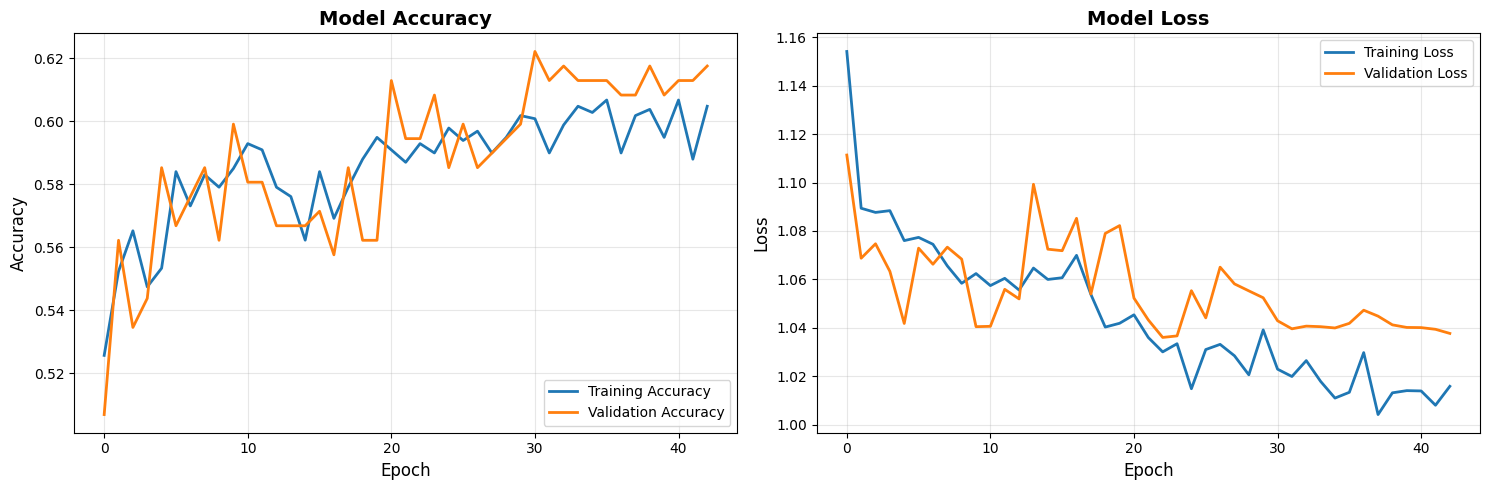


Best Epoch: 31
Best Validation Accuracy: 0.6221
Best Validation Loss: 1.0429


In [22]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best results
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\nBest Epoch: {best_epoch + 1}")
print(f"Best Validation Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"Best Validation Loss: {history.history['val_loss'][best_epoch]:.4f}")

## 9. Evaluasi Model pada Test Set

In [23]:
# Load best model
best_model = keras.models.load_model(os.path.join(model_dir, 'best_rnn_model.keras'))
print("Best model loaded successfully!")

# Evaluate pada test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n{'='*50}")
print(f"TEST SET EVALUATION")
print(f"{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'='*50}")

Best model loaded successfully!

TEST SET EVALUATION
Test Loss: 1.0468
Test Accuracy: 0.5917 (59.17%)

TEST SET EVALUATION
Test Loss: 1.0468
Test Accuracy: 0.5917 (59.17%)


In [24]:
# Prediksi pada test set
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification Report
print("\nCLASSIFICATION REPORT:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Accuracy Score
accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00         8
         fog       0.00      0.00      0.00        15
        rain       0.57      0.79      0.66        95
        snow       0.00      0.00      0.00         4
         sun       0.63      0.56      0.59        96

    accuracy                           0.59       218
   macro avg       0.24      0.27      0.25       218
weighted avg       0.52      0.59      0.55       218


Overall Accuracy: 0.5917 (59.17%)

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00         8
         fog       0.00      0.00      0.00        15
        rain       0.57      0.79      0.66        95
        snow       0.00      0.00      0.00         4
         sun       0.63      0.56      0.59        96

    accuracy            

## 10. Confusion Matrix

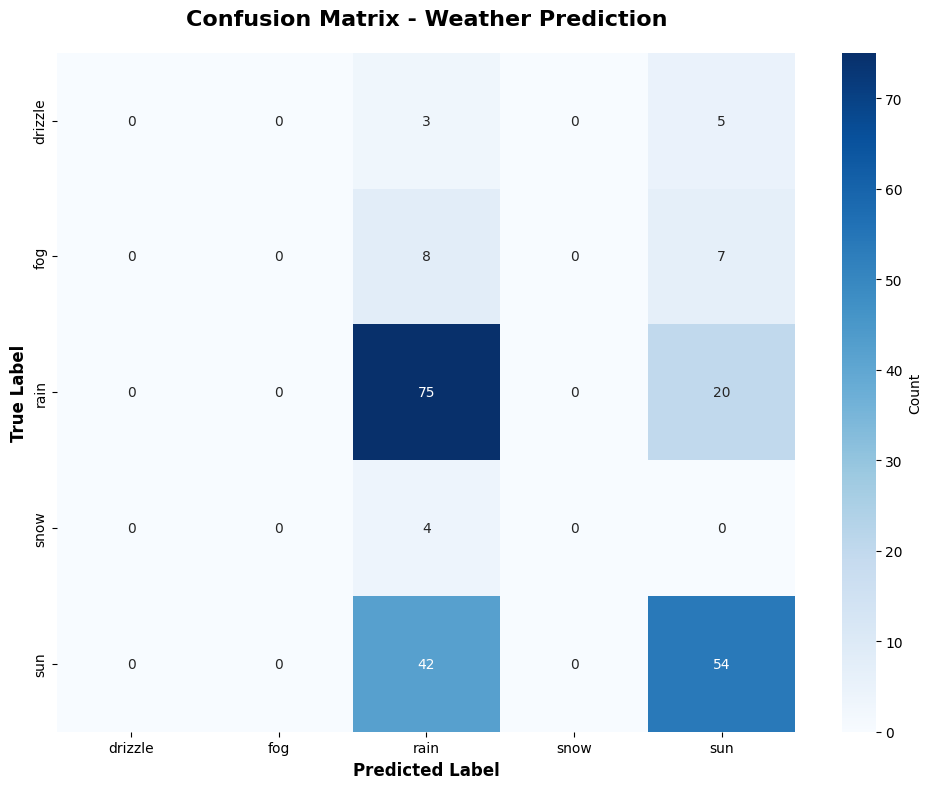


Confusion Matrix:
[[ 0  0  3  0  5]
 [ 0  0  8  0  7]
 [ 0  0 75  0 20]
 [ 0  0  4  0  0]
 [ 0  0 42  0 54]]

Class Labels: ['drizzle' 'fog' 'rain' 'snow' 'sun']


In [25]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Weather Prediction', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Print confusion matrix details
print("\nConfusion Matrix:")
print(cm)
print("\nClass Labels:", label_encoder.classes_)

## 11. Evaluasi per Kelas


Metrics per Class:
  Class  Precision   Recall  F1-Score
drizzle   0.000000 0.000000  0.000000
    fog   0.000000 0.000000  0.000000
   rain   0.568182 0.789474  0.660793
   snow   0.000000 0.000000  0.000000
    sun   0.627907 0.562500  0.593407


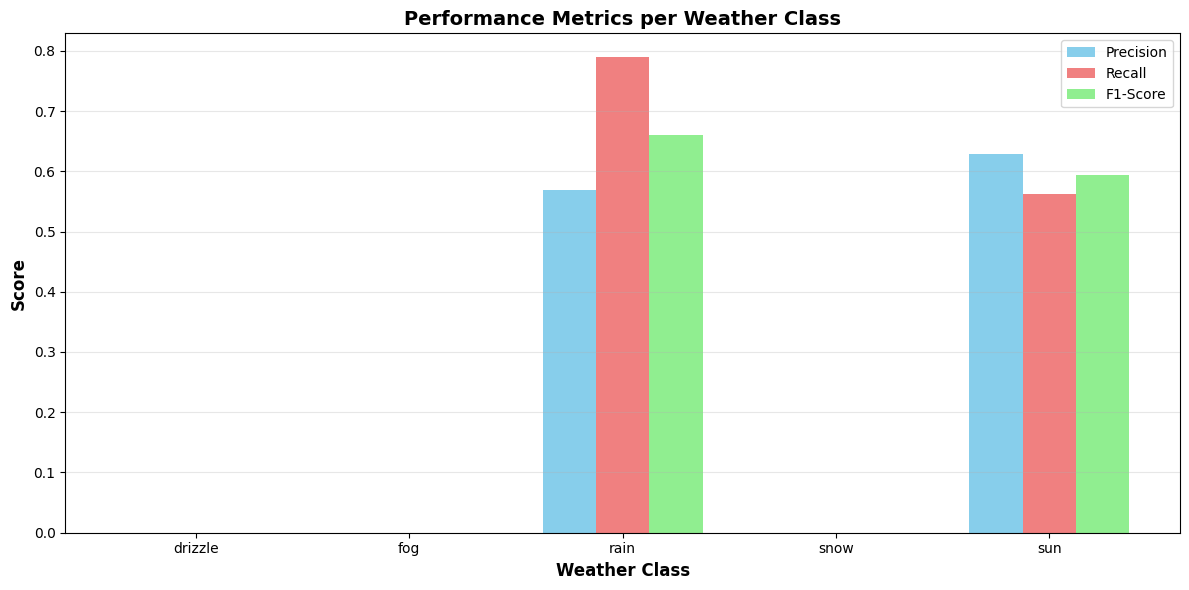

In [26]:
# Hitung metrik per kelas
from sklearn.metrics import precision_score, recall_score, f1_score

precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

# Buat DataFrame untuk visualisasi
metrics_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
})

print("\nMetrics per Class:")
print("="*60)
print(metrics_df.to_string(index=False))
print("="*60)

# Visualisasi
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(label_encoder.classes_))
width = 0.25

bars1 = ax.bar(x - width, precision_per_class, width, label='Precision', color='skyblue')
bars2 = ax.bar(x, recall_per_class, width, label='Recall', color='lightcoral')
bars3 = ax.bar(x + width, f1_per_class, width, label='F1-Score', color='lightgreen')

ax.set_xlabel('Weather Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance Metrics per Weather Class', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(label_encoder.classes_)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 12. Contoh Prediksi

In [27]:
# Ambil beberapa contoh prediksi
n_samples = 10
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

print("="*80)
print("CONTOH PREDIKSI MODEL")
print("="*80)

for idx in sample_indices:
    # Prediksi
    sample = X_test[idx:idx+1]
    pred_prob = best_model.predict(sample, verbose=0)
    pred_class = np.argmax(pred_prob)
    true_class = y_true[idx]
    
    pred_weather = label_encoder.classes_[pred_class]
    true_weather = label_encoder.classes_[true_class]
    confidence = pred_prob[0][pred_class] * 100
    
    # Status prediksi
    status = "✓ CORRECT" if pred_class == true_class else "✗ WRONG"
    
    print(f"\nSample {idx+1}:")
    print(f"  True Weather    : {true_weather}")
    print(f"  Predicted       : {pred_weather}")
    print(f"  Confidence      : {confidence:.2f}%")
    print(f"  Status          : {status}")
    print("-" * 80)

CONTOH PREDIKSI MODEL

Sample 27:
  True Weather    : rain
  Predicted       : rain
  Confidence      : 47.63%
  Status          : ✓ CORRECT
--------------------------------------------------------------------------------

Sample 26:
  True Weather    : sun
  Predicted       : rain
  Confidence      : 46.78%
  Status          : ✗ WRONG
--------------------------------------------------------------------------------

Sample 173:
  True Weather    : sun
  Predicted       : sun
  Confidence      : 70.11%
  Status          : ✓ CORRECT
--------------------------------------------------------------------------------

Sample 98:
  True Weather    : sun
  Predicted       : sun
  Confidence      : 44.50%
  Status          : ✓ CORRECT
--------------------------------------------------------------------------------

Sample 173:
  True Weather    : sun
  Predicted       : sun
  Confidence      : 70.11%
  Status          : ✓ CORRECT
------------------------------------------------------------------

## 14. Summary dan Kesimpulan

## 13. Model Improvements Summary

In [29]:
print("="*80)
print("MODEL SUMMARY - RNN WEATHER PREDICTION")
print("="*80)
print(f"\n📊 Dataset Information:")
print(f"   - Total samples: {len(df)}")
print(f"   - Features: {feature_columns}")
print(f"   - Target classes: {list(label_encoder.classes_)}")
print(f"   - Sequence length: {sequence_length} days")

print(f"\n🏗️ Model Architecture:")
print(f"   - Type: Complex Deep RNN (Vanilla RNN)")
print(f"   - Layers: 3 SimpleRNN layers (256→128→64) + 3 Dense layers (128→64→32)")
print(f"   - Total Parameters: {model.count_params():,}")
print(f"   - Dropout: Yes (0.2-0.4)")
print(f"   - Optimizer: Adam (lr=0.001)")

print(f"\n⚙️ Training Configuration:")
print(f"   - Epochs trained: {len(history.history['loss'])}")
print(f"   - Batch size: 16")
print(f"   - Early Stopping: Yes (patience=20)")
print(f"   - Learning Rate Scheduler: Yes (ReduceLROnPlateau, factor=0.3)")
print(f"   - Model Checkpoint: Yes (save best model)")

print(f"\n📈 Performance Metrics:")
print(f"   - Test Accuracy: {test_accuracy*100:.2f}%")
print(f"   - Test Loss: {test_loss:.4f}")

print(f"\n💾 Model Saved:")
print(f"   - Location: {os.path.join(model_dir, 'best_rnn_model.keras')}")

print("\n" + "="*80)
print("✅ Model training and evaluation completed successfully!")
print("="*80)

MODEL SUMMARY - RNN WEATHER PREDICTION

📊 Dataset Information:
   - Total samples: 1461
   - Features: ['precipitation', 'temp_max', 'temp_min', 'wind']
   - Target classes: ['drizzle', 'fog', 'rain', 'snow', 'sun']
   - Sequence length: 14 days

🏗️ Model Architecture:
   - Type: Complex Deep RNN (Vanilla RNN)
   - Layers: 3 SimpleRNN layers (256→128→64) + 3 Dense layers (128→64→32)
   - Total Parameters: 147,269
   - Dropout: Yes (0.2-0.4)
   - Optimizer: Adam (lr=0.001)

⚙️ Training Configuration:
   - Epochs trained: 43
   - Batch size: 16
   - Early Stopping: Yes (patience=20)
   - Learning Rate Scheduler: Yes (ReduceLROnPlateau, factor=0.3)
   - Model Checkpoint: Yes (save best model)

📈 Performance Metrics:
   - Test Accuracy: 59.17%
   - Test Loss: 1.0468

💾 Model Saved:
   - Location: ../model\best_rnn_model.keras

✅ Model training and evaluation completed successfully!
